In [24]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR10

from evaluate.calibration import nll, ece_loss
from evaluate.divergence import kld, disagreement
from evaluate.similarity import cka, gram_linear, gram_rbf

from al.methods import EnsembleVariationRatio

In [61]:
EXP_PATH = "./empirical/ensemble_*"
TRAIN_SIZE = 16000

logit_pts = glob(os.path.join(EXP_PATH, f"logits_size={TRAIN_SIZE}*.pt"))
print(f"{len(logit_pts)} predictions exist.")

5 predictions exist.


In [62]:
all_klds = np.zeros((len(logit_pts), len(logit_pts)))

for i in range(len(logit_pts)):
    logit_p = torch.load(logit_pts[i], map_location='cpu')
    prob_p  = F.softmax(logit_p, dim=-1).numpy()
    for j in range(len(logit_pts)):
        logit_q = torch.load(logit_pts[j], map_location='cpu')
        prob_q  = F.softmax(logit_q, dim=-1).numpy()
        all_klds[i, j] = kld(prob_p, prob_q).mean()

all_klds.mean() * (len(logit_pts)) / (len(logit_pts)-1)

0.14796716943383217

In [63]:
all_disagrees = np.zeros((len(logit_pts), len(logit_pts)))

for i in range(len(logit_pts)):
    logit_p = torch.load(logit_pts[i], map_location='cpu')
    for j in range(len(logit_pts)):
        logit_q = torch.load(logit_pts[j], map_location='cpu')
        all_disagrees[i, j] = disagreement(logit_p, logit_q)

all_disagrees.mean() * (len(logit_pts)) / (len(logit_pts)-1)

0.09285000562667846

In [64]:
all_accs = np.zeros((len(logit_pts),))
test_set = CIFAR10("/opt/datasets/cifar10", train=False)
all_targets = np.asarray(test_set.targets)

for i in range(len(logit_pts)):
    logit_p = torch.load(logit_pts[i], map_location='cpu')
    pred_p  = torch.argmax(logit_p, dim=-1).numpy()
    acc = (all_targets == pred_p).mean()

    all_accs[i] = acc

all_accs.mean()

0.87562

In [65]:
all_nlls = np.zeros((len(logit_pts),))

for i in range(len(logit_pts)):
    logit_p = torch.load(logit_pts[i], map_location='cpu')
    prob_p  = F.softmax(logit_p, dim=1).numpy()
    nll_p = nll(prob_p, all_targets)

    all_nlls[i] = nll_p

all_nlls.mean()

0.42351520657539365

In [66]:
all_eces = np.zeros((len(logit_pts),))

for i in range(len(logit_pts)):
    logit_p = torch.load(logit_pts[i], map_location='cpu')
    prob_p  = F.softmax(logit_p, dim=1).numpy()
    ece_p = ece_loss(prob_p, all_targets)

    all_eces[i] = ece_p

all_eces.mean()

0.02020247940778731

In [67]:
all_probs = []
all_preds = []
for i in range(len(logit_pts)):
    logit_p = torch.load(logit_pts[i], map_location='cpu')
    prob_p  = F.softmax(logit_p, dim=1)
    all_probs.append(prob_p.unsqueeze(1))
    all_preds.append(torch.argmax(logit_p, dim=1).unsqueeze(1))
all_probs = torch.cat(all_probs, dim=1)
all_preds = torch.cat(all_preds, dim=1)

In [68]:
all_klds = []
avg_probs = all_probs.mean(dim=1)
for i in range(len(logit_pts)):
    logit_p = torch.load(logit_pts[i], map_location='cpu')
    prob_p  = F.softmax(logit_p, dim=1).numpy()
    all_klds.append(kld(avg_probs.numpy(), prob_p))
all_klds = np.vstack(all_klds).T
avg_klds = np.mean(all_klds, axis=1)
avg_klds.shape

(10000,)

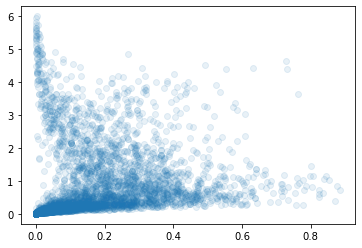

In [69]:
prob = np.take_along_axis(avg_probs, np.expand_dims(all_targets, axis=-1), axis=-1)
nlls = -np.log(prob, where=prob > 0.0)

plt.scatter(avg_klds, nlls, alpha=0.1)

In [70]:
np_prob = prob.squeeze().numpy()
np_nlls = nlls.squeeze().numpy()
vrs = EnsembleVariationRatio.calc_variation_ratio(all_preds.numpy(), 10)

In [71]:
print(f"Pearson's R: {pearsonr(vrs, np_prob)}")
print(f"Spearman's rho: {spearmanr(vrs, np_prob)}")

Pearson's R: (-0.674210635066376, 0.0)
Spearman's rho: SpearmanrResult(correlation=-0.5979015030446743, pvalue=0.0)
